In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import numpy as np
import gc
import os
import optuna
import sqlite3
import ray
import matplotlib.pyplot as plt
from optuna.integration import LightGBMPruningCallback
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Rutas de entrada y salida
input_path = './data/l_vm_completa_normalizada_fe.parquet'
output_train = './data/df_train.parquet'
output_val = './data/df_val.parquet'

# Periodos para división
periodo_train_max = 201908
periodos_val = [201909, 201910]

In [2]:
output_train_limpio = './data/df_train_limpio.parquet'
output_val_limpio = './data/df_val_limpio.parquet'

df_train_limpio = pd.read_parquet(output_train_limpio, engine='fastparquet')
df_val_limpio = pd.read_parquet(output_val_limpio, engine='fastparquet')

In [ ]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(
    label='CLASE_DELTA_ZSCORE',
    problem_type='regression',
    eval_metric='mean_absolute_error',
    verbosity=4,
    path='AutogluonModels/nn_gpu_full_train_v2'
).fit(
    train_data=df_train_limpio,         # tus 7 millones
    tuning_data=df_val_limpio,          # tus 0.5 millones separados temporalmente
    time_limit=7200,                    # 2 horas (ajustable según complejidad)
    use_bag_holdout=False,              # obligatorio si usás tuning_data
    presets='medium',                   # no activa stacking ni mezcla datos
    hyperparameters={
        'NN_TORCH': [{
            'num_epochs': 60,
            'learning_rate': 0.005,
            'dropout_prob': 0.1,
            'batch_size': 8192,         # mayor batch para mejor uso de GPU
            'hidden_size': 1024,         # red más potente
            'ag_args': {'name_suffix': 'GPU_Full'},
            'ag_args_fit': {'num_gpus': 1}
        }]
    }
)

Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 4 (Maximum Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.9.23
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #28~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri May 23 10:31:01 UTC 2
CPU Count:          28
GPU Count:          1
Memory Avail:       61.29 GB / 125.58 GB (48.8%)
Disk Space Avail:   109.45 GB / 543.17 GB (20.2%)
Presets specified: ['medium']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': False, 'use_bag_holdout': False}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': False,
 'calibrate': 'auto',
 'delay_bag_sets': False,
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
             'enable_callbacks': False,
             'enable_ray_logging': True,
          

In [3]:
# cargo el predictor entrenado
predictor = TabularPredictor.load('AutogluonModels/nn_gpu_full_train_v2')

In [4]:

# === Evaluación del modelo ===

lb = predictor.leaderboard(df_val_limpio, extra_metrics=['mean_absolute_error', 'median_absolute_error', 'r2'], silent=False)


                    model  score_test  mean_absolute_error  median_absolute_error        r2  score_val          eval_metric  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorchGPU_Full   -0.246012            -0.246012              -0.034256  0.557681  -0.246012  mean_absolute_error       13.728688      12.668378  2013.839719                13.728688               12.668378        2013.839719            1       True          1
1     WeightedEnsemble_L2   -0.246012            -0.246012              -0.034256  0.557681  -0.246012  mean_absolute_error       13.734031      12.670785  2013.845386                 0.005343                0.002407           0.005666            2       True          2


✅ Paso 1: Calcular errores de predicción

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y error absoluto
df_val_limpio['y_true'] = df_val_limpio['CLASE_DELTA_ZSCORE']
df_val_limpio['y_pred'] = predictor.predict(df_val_limpio)
df_val_limpio['error_abs'] = abs(df_val_limpio['y_true'] - df_val_limpio['y_pred'])
df_val_limpio['error_signed'] = df_val_limpio['y_pred'] - df_val_limpio['y_true']


📊 Paso 2: Histogramas de error absoluto y error signado

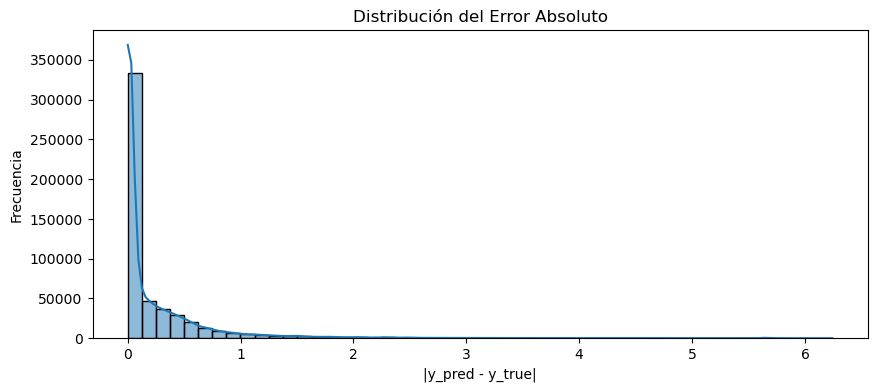

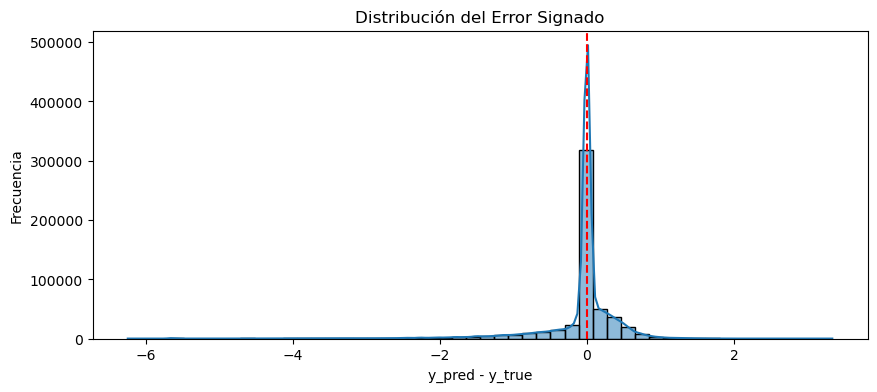

In [9]:
plt.figure(figsize=(10, 4))
sns.histplot(df_val_limpio['error_abs'], bins=50, kde=True)
plt.title('Distribución del Error Absoluto')
plt.xlabel('|y_pred - y_true|')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df_val_limpio['error_signed'], bins=50, kde=True)
plt.title('Distribución del Error Signado')
plt.xlabel('y_pred - y_true')
plt.ylabel('Frecuencia')
plt.axvline(0, color='red', linestyle='--')
plt.show()


📈 Paso 3: Error vs. Valor real (dispersión)


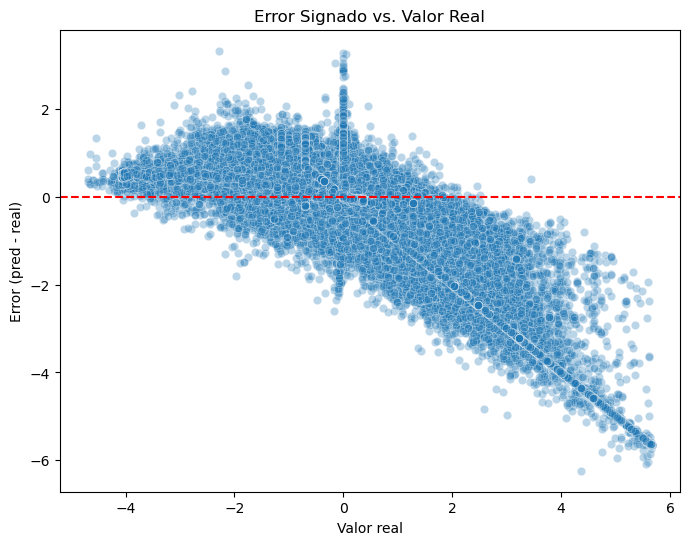

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_val_limpio['y_true'], y=df_val_limpio['error_signed'], alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Error Signado vs. Valor Real')
plt.xlabel('Valor real')
plt.ylabel('Error (pred - real)')
plt.show()


🧩 Paso 4: Promedio de error por grupo 

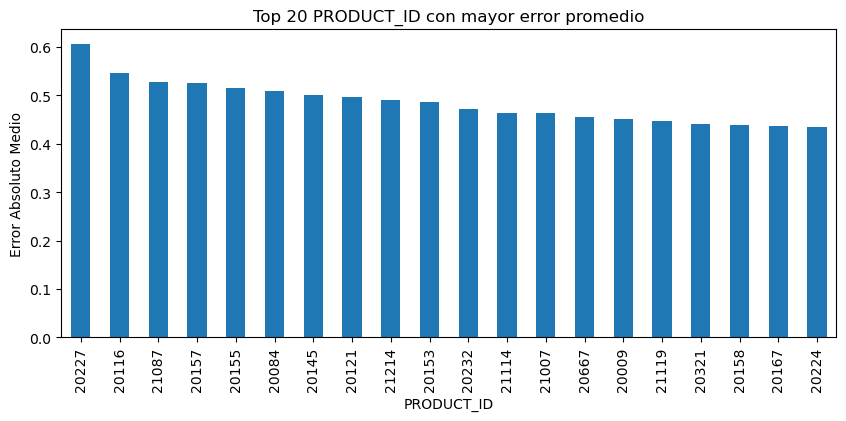

In [11]:
top_errores_producto = df_val_limpio.groupby('PRODUCT_ID')['error_abs'].mean().sort_values(ascending=False).head(20)
top_errores_producto.plot(kind='bar', figsize=(10,4), title='Top 20 PRODUCT_ID con mayor error promedio')
plt.ylabel('Error Absoluto Medio')
plt.show()


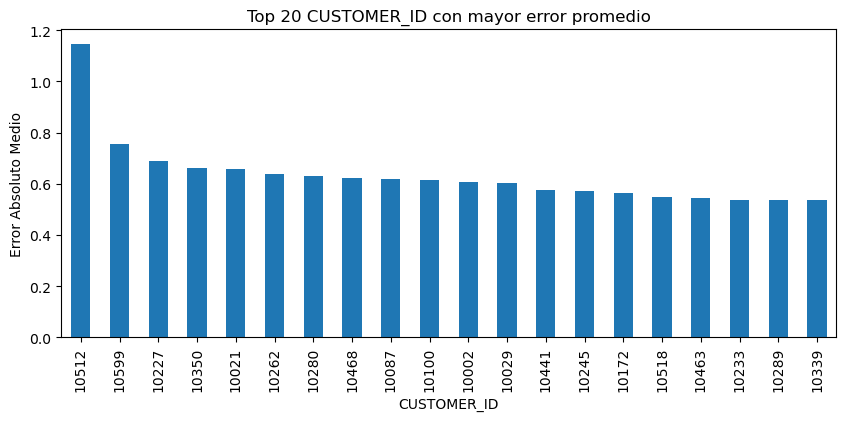

In [12]:
top_errores_producto = df_val_limpio.groupby('CUSTOMER_ID')['error_abs'].mean().sort_values(ascending=False).head(20)
top_errores_producto.plot(kind='bar', figsize=(10,4), title='Top 20 CUSTOMER_ID con mayor error promedio')
plt.ylabel('Error Absoluto Medio')
plt.show()

In [16]:
output_train_limpio = './data/df_train_limpio.parquet'
output_val_limpio = './data/df_val_limpio.parquet'

df_train_limpio = pd.read_parquet(output_train_limpio, engine='fastparquet')
df_val_limpio = pd.read_parquet(output_val_limpio, engine='fastparquet')
df_full = pd.concat([df_train_limpio, df_val_limpio], ignore_index=True)
del df_train_limpio, df_val_limpio
gc.collect()

797

In [18]:
print(df_full.columns.to_list())
print(df_full.shape)

['PERIODO', 'ANIO', 'MES', 'MES_SIN', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID', 'PRODUCT_ID', 'PLAN_PRECIOS_CUIDADOS', 'CUST_REQUEST_QTY', 'ORDINAL', 'ANTIG_CLIENTE', 'ANTIG_PRODUCTO', 'CANT_PROD_CLI_PER', 'DIAS_EN_MES', 'MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID', 'MESES_SIN_COMPRAR_PRODUCT_ID', 'MESES_SIN_COMPRAR_CUSTOMER_ID', 'CUST_REQUEST_QTY_SQRT', 'CUST_REQUEST_QTY_LOG1P', 'ORDINAL_SQ', 'ORDINAL_SQRT', 'ORDINAL_LOG1P', 'ANTIG_CLIENTE_SQ', 'ANTIG_CLIENTE_SQRT', 'ANTIG_CLIENTE_LOG1P', 'ANTIG_PRODUCTO_SQ', 'ANTIG_PRODUCTO_SQRT', 'ANTIG_PRODUCTO_LOG1P', 'CANT_PROD_CLI_PER_SQ', 'CANT_PROD_CLI_PER_SQRT', 'CANT_PROD_CLI_PER_LOG1P', 'MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID_SQ', 'MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID_SQRT', 'MESES_SIN_COMPRAR_PRODUCT_CUSTOMER_ID_LOG1P', 'MESES_SIN_COMPRAR_PRODUCT_ID_SQ', 'MESES_SIN_COMPRAR_PRODUCT_ID_SQRT', 'MESES_SIN_COMPRAR_PRODUCT_ID_LOG1P', 'MESES_SIN_COMPRAR_CUSTOMER_ID_SQ', 'MESES_SIN_COMPRAR_CUSTOMER_ID_SQRT', '

In [ ]:

predictor = TabularPredictor(
    label='CLASE_DELTA_ZSCORE',
    problem_type='regression',
    eval_metric='mean_absolute_error',
    verbosity=4,
    path='AutogluonModels/nn_gpu_full_train_final'
).fit(
    train_data=df_full,         # tus 7 millones
    time_limit=7200,                    # 2 horas (ajustable según complejidad)
    use_bag_holdout=False,              # obligatorio si usás tuning_data
    presets='medium',                   # no activa stacking ni mezcla datos
    hyperparameters={
        'NN_TORCH': [{
            'num_epochs': 28,
            'learning_rate': 0.005,
            'dropout_prob': 0.1,
            'batch_size': 8192,         # mayor batch para mejor uso de GPU
            'hidden_size': 1024,         # red más potente
            'ag_args': {'name_suffix': 'GPU_Full_final'},
            'ag_args_fit': {'num_gpus': 1}
        }]
    }
)

Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 4 (Maximum Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.9.23
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #28~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri May 23 10:31:01 UTC 2
CPU Count:          28
GPU Count:          1
Memory Avail:       78.10 GB / 125.58 GB (62.2%)
Disk Space Avail:   99.44 GB / 543.17 GB (18.3%)
Presets specified: ['medium']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': False, 'use_bag_holdout': False}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': False,
 'calibrate': 'auto',
 'delay_bag_sets': False,
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
             'enable_callbacks': False,
             'enable_ray_logging': True,
           

In [ ]:
# Cargo los datos sobre los que quiero hacer predicciones
input_path = './data/l_vm_completa_normalizada_fe.parquet'
df_pred_full = pd.read_parquet(input_path, engine='fastparquet')
# Dejo solo los datos del periodo 201910 y que A_PREDECIR sea True
# Filtrar solo los datos del periodo 201910 y donde A_PREDECIR sea True
df_pred_full = df_pred_full[
    (df_pred_full['PERIODO'] == 201910) & (df_pred_full['A_PREDECIR'] == True)
].drop(columns=['CLASE_ZSCORE', 'CLASE_DELTA_ZSCORE'])

In [ ]:
# Realizar las predicciones usando el predictor original
predictions = predictor.predict(df_pred_full)
# Agregar las predicciones al DataFrame original
df_pred_full['CLASE_DELTA_ZSCORE'] = predictions

In [ ]:
# Imprimir la lista de columas del DataFrame con las predicciones
print("Columnas del DataFrame con las predicciones:")
print(df_pred_full.columns.tolist())

In [ ]:
# Dernormalizar la columna CLASE_DELTA_ZSCORE
df_pred_full['CLASE_DELTA'] = df_pred_full['CLASE_DELTA_ZSCORE'] * df_pred_full['CLASE_DELTA_STD'] + df_pred_full['CLASE_DELTA_MEAN']
df_pred_full['TN'] = df_pred_full['TN_ZSCORE'] * df_pred_full['TN_STD'] + df_pred_full['TN_MEAN']
# Agregar la columna TN_PREDICT que sea la suma de TN y CLASE_DELTA y si es menor que cero, poner cero
df_pred_full['TN_PREDICT'] = df_pred_full['TN'] + df_pred_full['CLASE_DELTA']
df_pred_full['TN_PREDICT'] = df_pred_full['TN_PREDICT'].clip(lower=0)

In [ ]:
# Generar Dataframe que contenga por cada PRODUCT_ID la suma de TN_PREDICT
df_final = df_pred_full.groupby('PRODUCT_ID').agg({'TN_PREDICT': 'sum'}).reset_index()
df_final = df_final.rename(columns={'PRODUCT_ID': 'product_id', 'TN_PREDICT': 'tn'})
# Guardar el DataFrame df_final en un archivo CSV
df_final.to_csv('./modelos/autoglun_normalizando_clase_delta.csv', index=False)
df_final.shape

# Para instalar AutoGluon con soporte para `autogluon.core.space` en conda, ejecuta:
# 
# conda install -c conda-forge autogluon
# 
# O si prefieres usar pip dentro de tu entorno conda:
# 
# pip install autogluon
# 
# Luego podrás usar:
# from autogluon.core import space as ag